**Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.holiday import USFederalHolidayCalendar

# Load Datasets
product_a = pd.read_excel('/content/ProductA.xlsx')
fb_impressions = pd.read_excel('/content/ProductA_fb_impressions (1).xlsx')
google_clicks = pd.read_excel('/content/ProductA_google_clicks (1).xlsx')
#display the rows
print(product_a.head())
print(fb_impressions.head())
print(google_clicks.head())
merged_df = product_a.merge(fb_impressions, on='Day Index', how='outer').merge(google_clicks, on='Day Index', how='outer')

   Day Index  Quantity
0 2021-12-01        14
1 2021-12-02        10
2 2021-12-03        13
3 2021-12-04        22
4 2021-12-05        33
   Day Index  Impressions
0 2021-12-01          620
1 2021-12-02          890
2 2021-12-03          851
3 2021-12-04          881
4 2021-12-05          678
   Day Index  Clicks
0 2021-12-01     445
1 2021-12-02     433
2 2021-12-03     424
3 2021-12-04     427
4 2021-12-05     451


In [ ]:
rows, columns = merged_df.shape

# print the total number of rows and columns
print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")

Total number of rows: 212
Total number of columns: 4


In [ ]:
merged_df.info()
merged_df.isnull().sum()
merged_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Clicks       212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


(212, 4)

**outliers for each column individually**

Text(0.5, 1.0, 'Quantity - After')

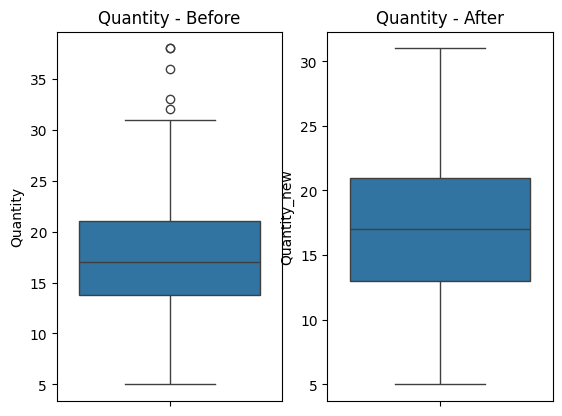

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df
    filtered_df = remove_outliers_iqr(merged_df, 'Quantity')

filtered_df = remove_outliers_iqr(merged_df, 'Quantity')
merged_df['Quantity_new'] = filtered_df['Quantity']
plt.subplot(1, 2, 1)
sns.boxplot(y=merged_df['Quantity'])
plt.title('Quantity - Before')
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['Quantity_new'].dropna())
plt.title('Quantity - After')

Number of outliers in each column:
Day Index       0
Quantity        5
Impressions     0
Clicks          0
Quantity_new    0
dtype: int64
     Day Index  Quantity  Impressions  Clicks  Quantity_new
4   2021-12-05        33          678     451           NaN
9   2021-12-10        38         1129     391           NaN
78  2022-02-17        38         2351     505           NaN
113 2022-03-24        32         1321     547           NaN
142 2022-04-22        36         1163     470           NaN


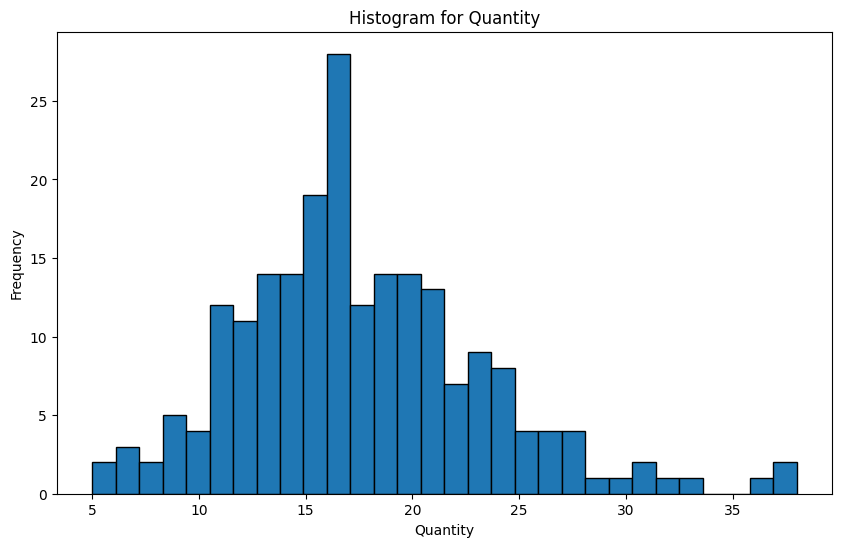

In [ ]:
Q1 = merged_df.quantile(0.25)
Q3 = merged_df.quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = (merged_df < (Q1 - 1.5 * IQR)) | (merged_df > (Q3 + 1.5 * IQR))

# Print number of outliers in each column
print("Number of outliers in each column:")
print(outliers.sum())

# Display the outliers in the dataset
outlier_rows = merged_df[outliers.any(axis=1)]
print(outlier_rows)

# Plot a histogram for the 'Quantity' column
plt.figure(figsize=(10,6))
plt.hist(merged_df['Quantity'], bins=30, edgecolor='black')
plt.title('Histogram for Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

Outlier Rows:
      Day Index  Quantity  Impressions  Clicks  Quantity_new
4   2021-12-05        33          678     451           NaN
9   2021-12-10        38         1129     391           NaN
78  2022-02-17        38         2351     505           NaN
113 2022-03-24        32         1321     547           NaN
142 2022-04-22        36         1163     470           NaN
First 5 rows with original and new quantity:
    Quantity  quantity_new
0        14          15.4
1        10          11.0
2        13          14.3
3        22          24.2
4        33          36.3


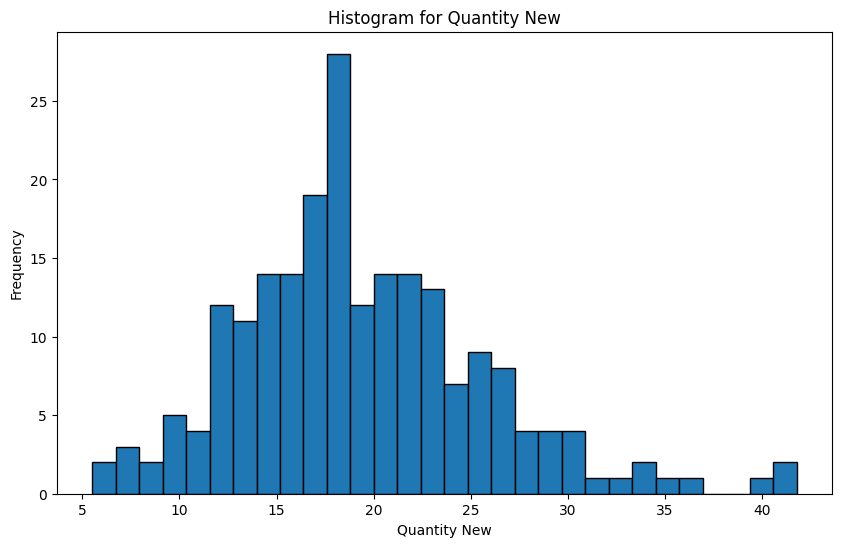

In [ ]:
# Filter out rows with outliers
outlier_rows = merged_df[outliers.any(axis=1)]
print("Outlier Rows:\n", outlier_rows)

# Add a new column 'quantity_new' by applying a transformation to 'Quantity'
# For example, increasing the Quantity by 10%
merged_df['quantity_new'] = merged_df['Quantity'] * 1.1

# Verify the new column
print("First 5 rows with original and new quantity:\n", merged_df[['Quantity', 'quantity_new']].head())

# Plot a histogram for the 'quantity_new' column
plt.figure(figsize=(10, 6))
plt.hist(merged_df['quantity_new'], bins=30, edgecolor='black')
plt.title('Histogram for Quantity New')
plt.xlabel('Quantity New')
plt.ylabel('Frequency')
plt.show()


**Feature Engineerig**

Feature engineered DataFrame with Quantity_new:
  Date Index  Quantity  Clicks  Impressions  Year  Month  Weekday  Day  \
0 2023-01-01        25     258         4774  2023      1        6    1   
1 2023-01-02        99     489         3166  2023      1        0    2   
2 2023-01-03        28     397         4923  2023      1        1    3   
3 2023-01-04        54     140         1697  2023      1        2    4   
4 2023-01-05        14     414         2102  2023      1        3    5   

   Quarter  Is_Weekend  Season  Is_Month_Start  Is_Month_End  \
0        1           1  Winter               1             0   
1        1           0  Winter               0             0   
2        1           0  Winter               0             0   
3        1           0  Winter               0             0   
4        1           0  Winter               0             0   

   Is_Quarter_Start  Is_Quarter_End  Is_Year_Start  Is_Year_End  Quantity_new  
0                 1               0       

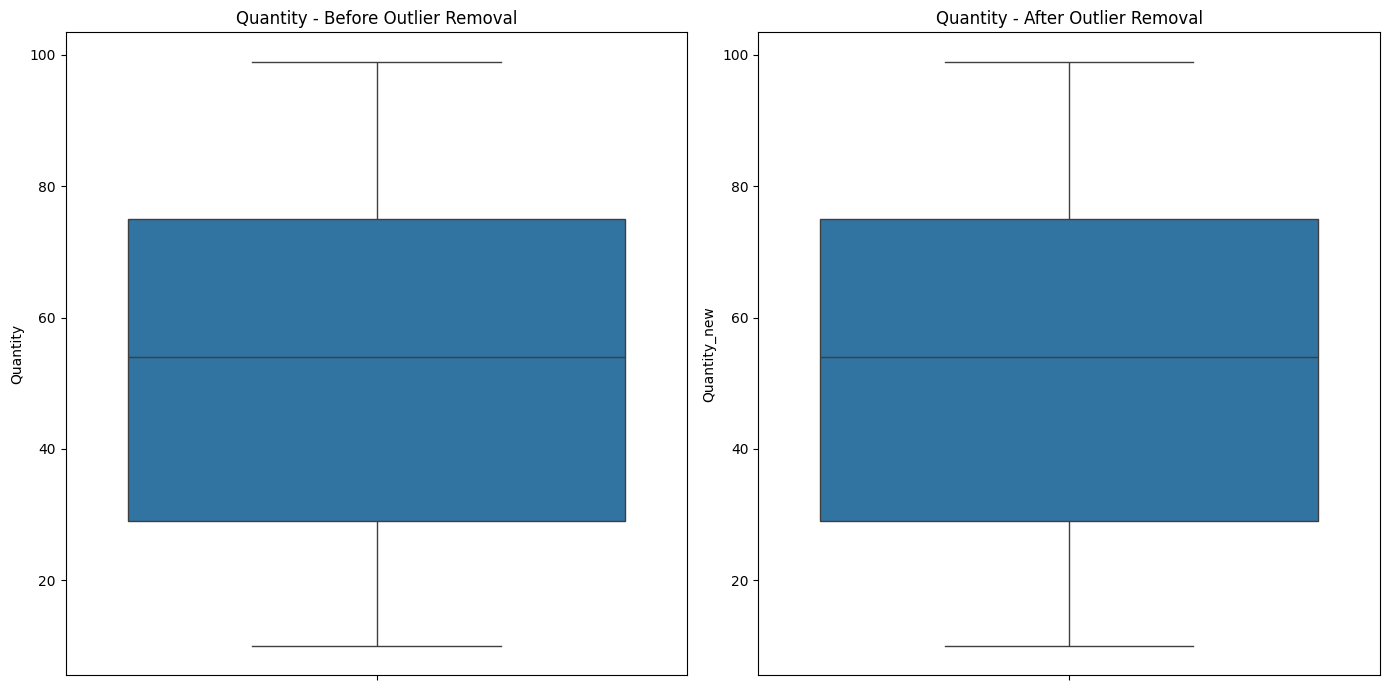

  Date Index  Quantity  Clicks  Impressions  Year  Month  Weekday  Day  \
0 2023-01-01        25     258         4774  2023      1        6    1   
1 2023-01-02        99     489         3166  2023      1        0    2   
2 2023-01-03        28     397         4923  2023      1        1    3   
3 2023-01-04        54     140         1697  2023      1        2    4   
4 2023-01-05        14     414         2102  2023      1        3    5   

   Quarter  Is_Weekend  ... Weekday_3  Weekday_4  Weekday_5  Weekday_6  \
0        1           1  ...         0          0          0          1   
1        1           0  ...         0          0          0          0   
2        1           0  ...         0          0          0          0   
3        1           0  ...         0          0          0          0   
4        1           0  ...         1          0          0          0   

   Weekday_Sin  Weekday_Cos  Is_Holiday  Days_Until_Next_Holiday  \
0    -0.781831     0.623490           0   

In [ ]:
# Create a sample dataset
data = {
    'Date Index': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Quantity': np.random.randint(10, 100, size=100),
    'Clicks': np.random.randint(100, 500, size=100),
    'Impressions': np.random.randint(1000, 5000, size=100)
}

merged_df = pd.DataFrame(data)

# Function to determine the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Convert 'Date Index' to datetime
merged_df['Date Index'] = pd.to_datetime(merged_df['Date Index'])

# Feature engineering based on date
merged_df['Year'] = merged_df['Date Index'].dt.year
merged_df['Month'] = merged_df['Date Index'].dt.month
merged_df['Weekday'] = merged_df['Date Index'].dt.weekday
merged_df['Day'] = merged_df['Date Index'].dt.day
merged_df['Quarter'] = merged_df['Date Index'].dt.quarter
merged_df['Is_Weekend'] = (merged_df['Date Index'].dt.weekday >= 5).astype(int)
merged_df['Season'] = merged_df['Date Index'].apply(get_season)

# Advanced date features
merged_df['Is_Month_Start'] = merged_df['Date Index'].dt.is_month_start.astype(int)
merged_df['Is_Month_End'] = merged_df['Date Index'].dt.is_month_end.astype(int)
merged_df['Is_Quarter_Start'] = merged_df['Date Index'].dt.is_quarter_start.astype(int)
merged_df['Is_Quarter_End'] = merged_df['Date Index'].dt.is_quarter_end.astype(int)
merged_df['Is_Year_Start'] = merged_df['Date Index'].dt.is_year_start.astype(int)
merged_df['Is_Year_End'] = merged_df['Date Index'].dt.is_year_end.astype(int)

# Remove outliers for Quantity and create a new column 'Quantity_new'
quantity_no_outliers = remove_outliers_iqr(merged_df, 'Quantity')['Quantity']
merged_df['Quantity_new'] = merged_df.apply(
    lambda row: row['Quantity'] if row['Quantity'] in quantity_no_outliers.values else np.nan, axis=1
)

# Print the resulting DataFrame after feature engineering and outlier removal
print("Feature engineered DataFrame with Quantity_new:")
print(merged_df.head())

# Plotting box plots before and after outlier removal
plt.figure(figsize=(14, 7))

# Box plot before outlier removal
plt.subplot(1, 2, 1)
sns.boxplot(y=merged_df['Quantity'])
plt.title('Quantity - Before Outlier Removal')

# Box plot after outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['Quantity_new'].dropna())
plt.title('Quantity - After Outlier Removal')

plt.tight_layout()
plt.show()

# One-hot encode the 'Weekday' column
weekday_dummies = pd.get_dummies(merged_df['Weekday'], prefix='Weekday', dtype=int)
merged_df = pd.concat([merged_df, weekday_dummies], axis=1)

# Sine and cosine transformations to capture cyclic nature of the days of the week
merged_df['Weekday_Sin'] = np.sin(2 * np.pi * merged_df['Weekday'] / 7)
merged_df['Weekday_Cos'] = np.cos(2 * np.pi * merged_df['Weekday'] / 7)

# Adding holiday features
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=merged_df['Date Index'].min(), end=merged_df['Date Index'].max())
merged_df['Is_Holiday'] = merged_df['Date Index'].isin(holidays).astype(int)

# Function to calculate days until the next holiday
def days_until_next_holiday(date):
    future_holidays = holidays[holidays > date]
    if not future_holidays.empty:
        return (future_holidays.min() - date).days
    else:
        return np.nan

merged_df['Days_Until_Next_Holiday'] = merged_df['Date Index'].apply(days_until_next_holiday)

# Is business day
merged_df['Is_Business_Day'] = (merged_df['Date Index'].dt.dayofweek < 5).astype(int)

# Number of business days until the end of the month
merged_df['Business_Days_Until_Month_End'] = merged_df['Date Index'].apply(
    lambda x: np.busday_count(x.date(), (x + pd.offsets.MonthEnd()).date())
)

# Display the first few rows with new date features
print(merged_df.head())


**Visualization**

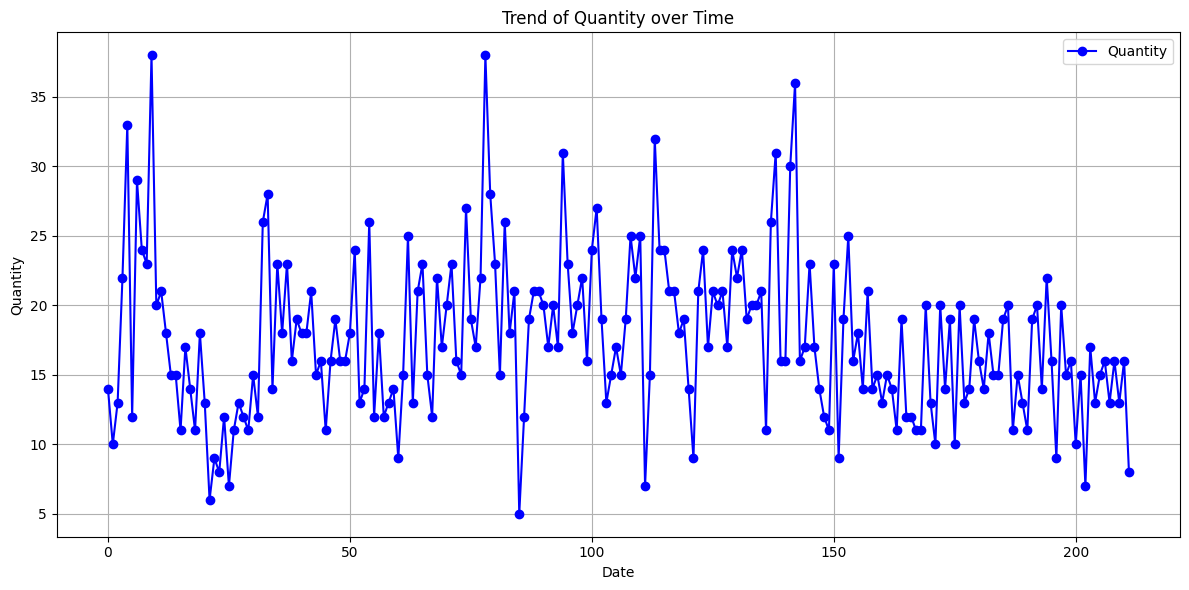

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(product_a_df.index, product_a_df['Quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Trend of Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

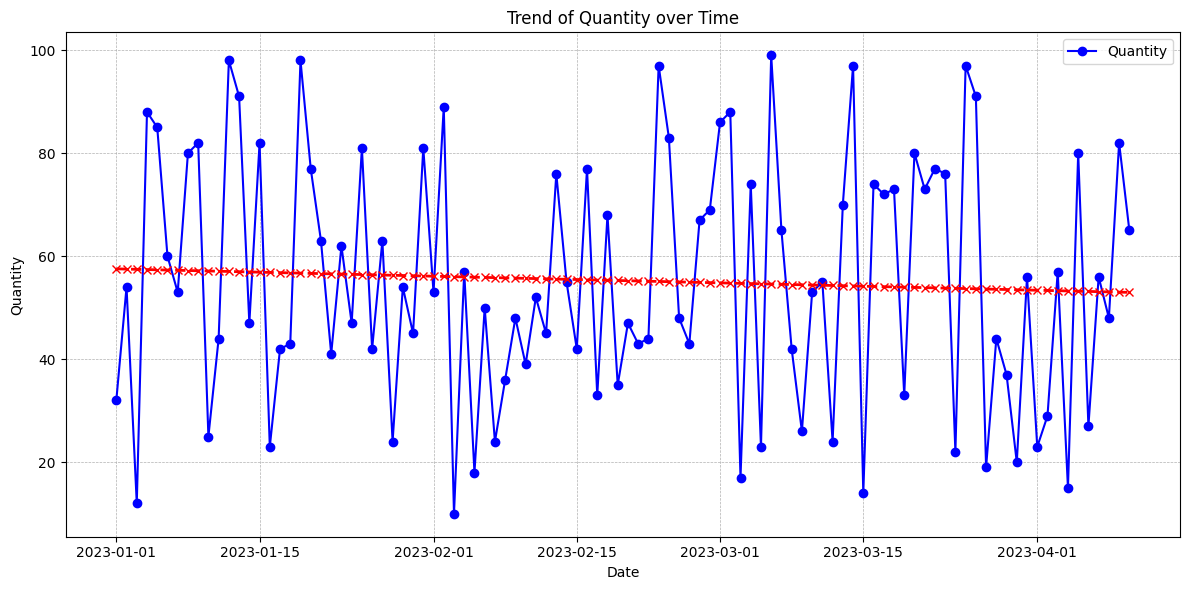

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3012
Date:                Tue, 16 Jul 2024   Prob (F-statistic):              0.584
Time:                        07:49:32   Log-Likelihood:                -459.78
No. Observations:                 100   AIC:                             923.6
Df Residuals:                      98   BIC:                             928.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.5436      4.816     11.947      0.0

In [ ]:

dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
quantity = np.random.randint(10, 100, size=100)
product_a_df = pd.DataFrame({'Date': dates, 'Quantity': quantity}).set_index('Date')

plt.figure(figsize=(12, 6))
plt.plot(product_a_df.index, product_a_df['Quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Trend of Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Perform linear regression using statsmodels
X = sm.add_constant(range(len(product_a_df)))  t
y = product_a_df['Quantity']

model = sm.OLS(y, X)
results = model.fit()

# Plotting the regression line
plt.plot(product_a_df.index, results.predict(X), marker='x', color='red', linestyle='--', linewidth=2, label='Linear Regression')

plt.tight_layout()
plt.show()

# Print regression summary
print(results.summary())


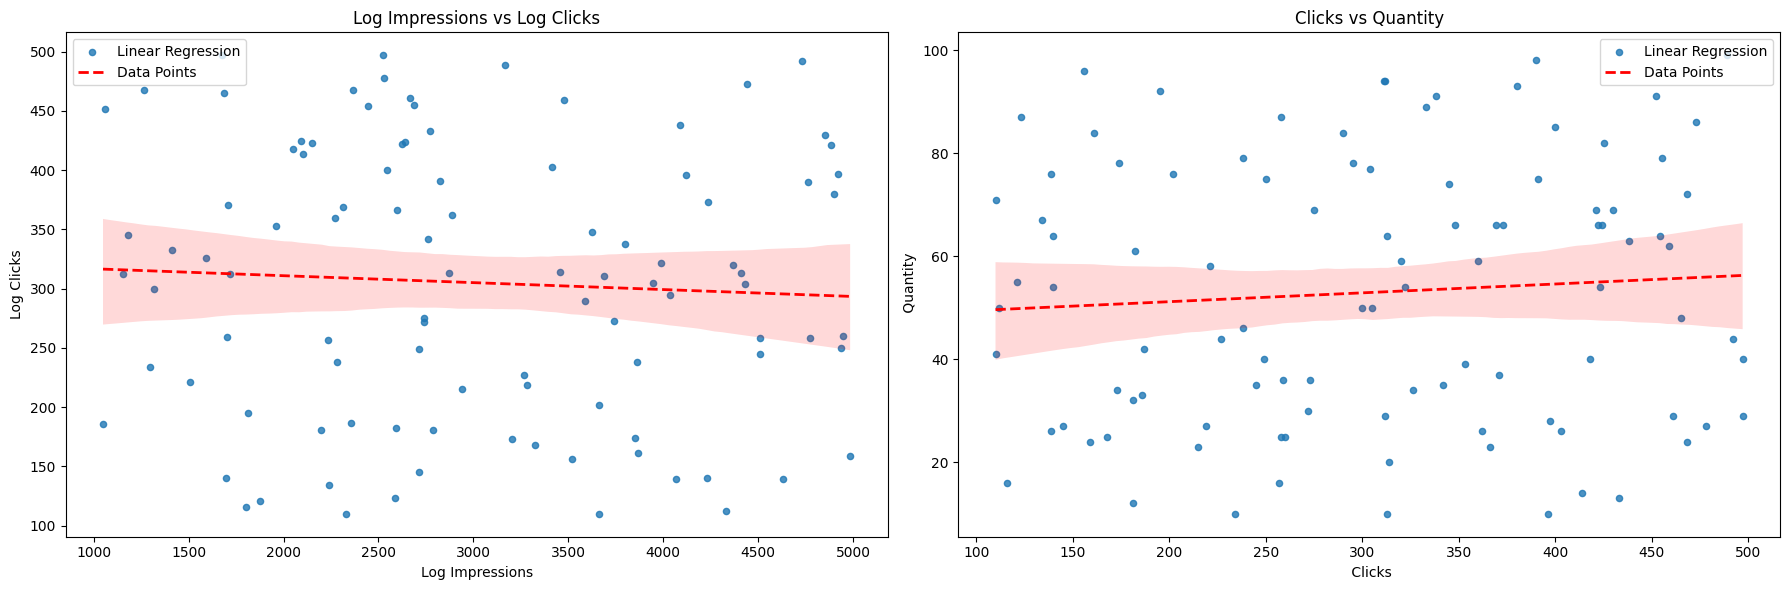

Regression Summary for  Impressions vs  Clicks:
                            OLS Regression Results                            
Dep. Variable:                 Clicks   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3222
Date:                Tue, 16 Jul 2024   Prob (F-statistic):              0.572
Time:                        07:54:10   Log-Likelihood:                -614.90
No. Observations:                 100   AIC:                             1234.
Df Residuals:                      98   BIC:                             1239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
co

In [ ]:
import seaborn as sns

plt.figure(figsize=(18, 6))

# Scatter plot 1: Log Impressions vs Log Clicks
plt.subplot(1, 2, 1)
sns.regplot(x='Impressions', y='Clicks', data=merged_df, scatter_kws={'s': 20}, line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2})
plt.title('Log Impressions vs Log Clicks')
plt.xlabel('Log Impressions')
plt.ylabel('Log Clicks')
plt.legend(['Linear Regression', 'Data Points'])

# Perform linear regression for Log Impressions vs Log Clicks
X1 = sm.add_constant(merged_df['Impressions'])
y1 = merged_df['Clicks']
model1 = sm.OLS(y1, X1)
results1 = model1.fit()

# Scatter plot 2: Log Clicks vs Log Quantity
plt.subplot(1, 2, 2)
sns.regplot(x='Clicks', y='Quantity', data=merged_df, scatter_kws={'s': 20}, line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2})
plt.title('Clicks vs Quantity')
plt.xlabel(' Clicks')
plt.ylabel(' Quantity')
plt.legend(['Linear Regression', 'Data Points'])


X2 = sm.add_constant(merged_df['Clicks'])
y2 = merged_df['Quantity']
model2 = sm.OLS(y2, X2)
results2 = model2.fit()

plt.tight_layout()
plt.show()

print("Regression Summary for  Impressions vs  Clicks:")
print(results1.summary())
print("\nRegression Summary for  Clicks vs  Quantity:")
print(results2.summary())


**Coorelation Matrix**

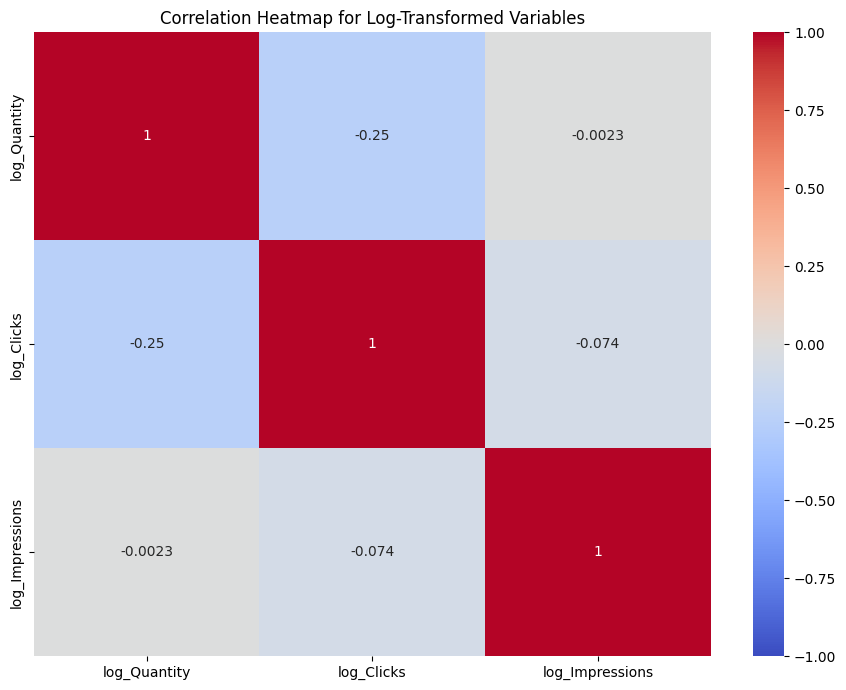

In [ ]:

data = {
    'Date Index': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Quantity': np.random.randint(10, 100, size=100),
    'Clicks': np.random.randint(100, 500, size=100),
    'Impressions': np.random.randint(1000, 5000, size=100)
}

merged_df = pd.DataFrame(data)


merged_df['log_Quantity'] = np.log1p(merged_df['Quantity'])
merged_df['log_Clicks'] = np.log1p(merged_df['Clicks'])
merged_df['log_Impressions'] = np.log1p(merged_df['Impressions'])

# Calculate the correlation matrix
correlation_matrix = merged_df[['log_Quantity', 'log_Clicks', 'log_Impressions']].corr()

# Plotting the heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Log-Transformed Variables')
plt.tight_layout()
plt.show()


In [ ]:
def adf_test(series, name=None):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test Results for {name if name else "Series"}')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is non-stationary (fail to reject H0)")

# Function to perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
def kpss_test(series, name=None):
    result = kpss(series.dropna(), regression='c')
    print(f'KPSS Test Results for {name if name else "Series"}')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[1] >= 0.05:
        print("Series is stationary (fail to reject H0)")
    else:
        print("Series is non-stationary (reject H0)")

# Apply tests to each series
adf_test(merged_df['Quantity'], 'Quantity')
print()
kpss_test(merged_df['Quantity'], 'Quantity')
print()

adf_test(merged_df['Clicks'], 'Clicks')
print()
kpss_test(merged_df['Clicks'], 'Clicks')
print()

adf_test(merged_df['Impressions'], 'Impressions')
print()
kpss_test(merged_df['Impressions'], 'Impressions')

ADF Test Results for Quantity
Test Statistic: -7.382480321250825
p-value: 8.401749225074972e-11
Critical Values:
	1%: -3.4996365338407074
	5%: -2.8918307730370025
	10%: -2.5829283377617176
Series is stationary (reject H0)

KPSS Test Results for Quantity
Test Statistic: 0.09001257968340645
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is stationary (fail to reject H0)

ADF Test Results for Clicks
Test Statistic: -8.620720120012304
p-value: 6.115674864792782e-14
Critical Values:
	1%: -3.498198082189098
	5%: -2.891208211860468
	10%: -2.5825959973472097
Series is stationary (reject H0)

KPSS Test Results for Clicks
Test Statistic: 0.6476919858730267
p-value: 0.018300728556997572
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is non-stationary (reject H0)

ADF Test Results for Impressions
Test Statistic: -10.820485086482432
p-value: 1.8109267278157332e-19
Critical Values:
	1%: -3.498198082189098
	5%: -2.891208211860468
	10%: -2.5

<ipython-input-34-66c5799cfdd3>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-34-66c5799cfdd3>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


**Laggeg effects**

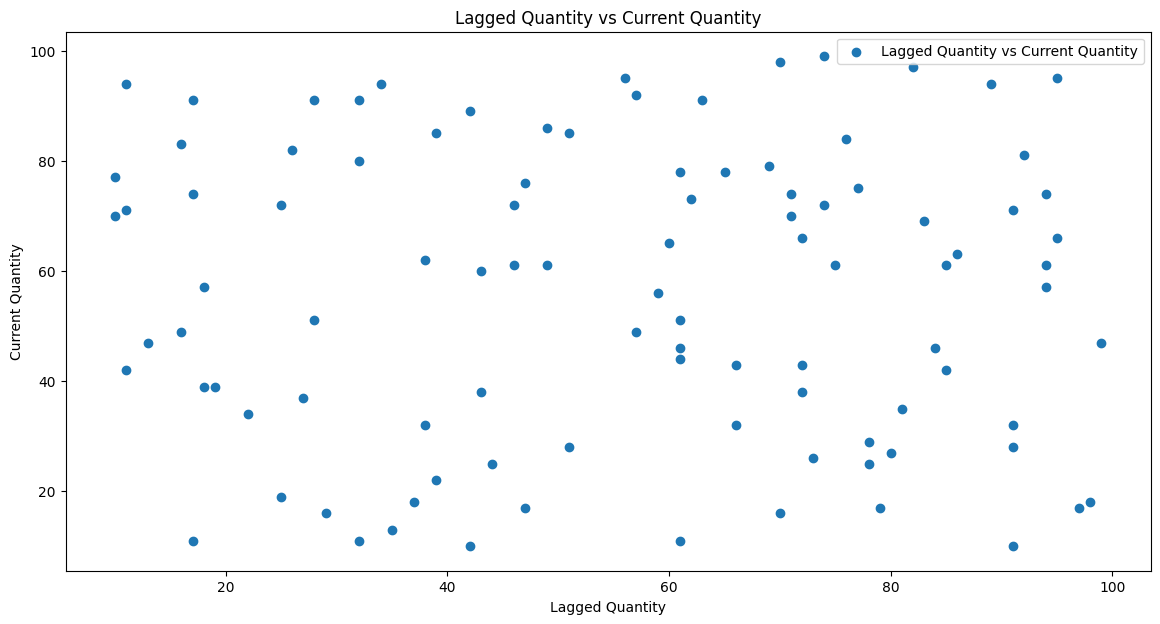

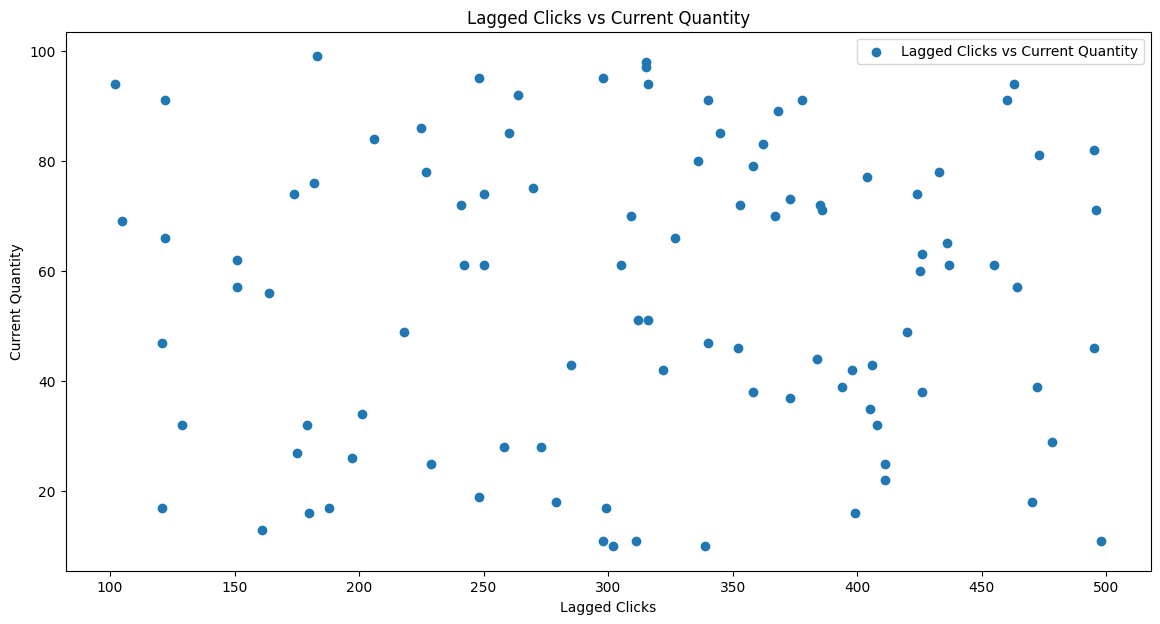

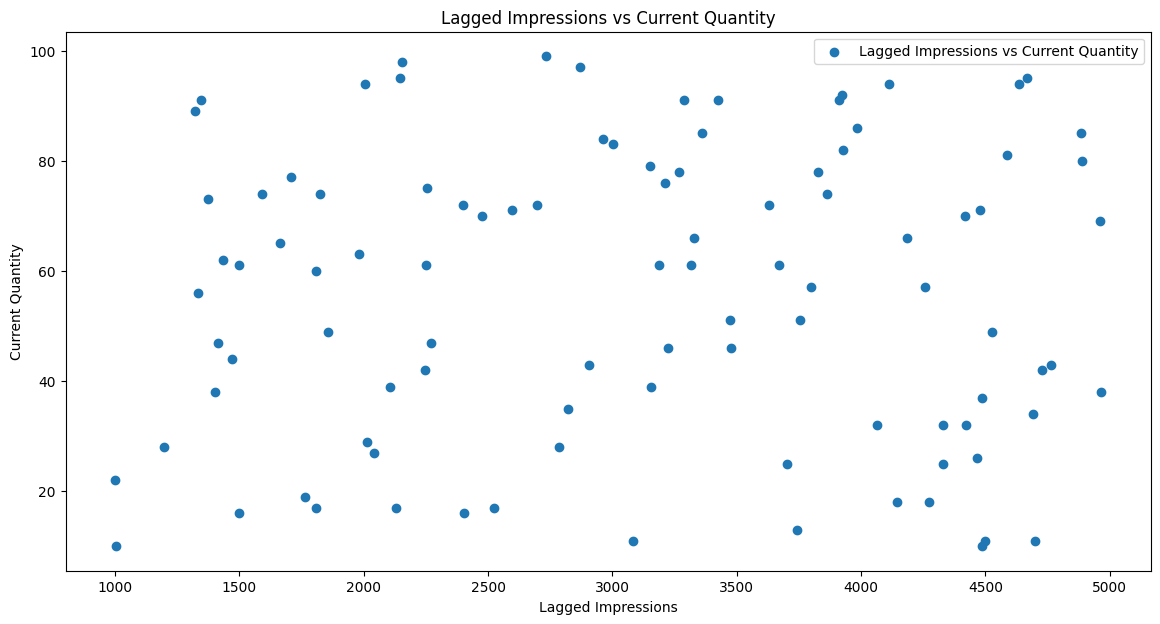

In [ ]:
merged_df['Lagged_Quantity'] = merged_df['Quantity'].shift(1)
merged_df['Lagged_Clicks'] = merged_df['Clicks'].shift(1)
merged_df['Lagged_Impressions'] = merged_df['Impressions'].shift(1)

# Drop NaN rows introduced by shifting
merged_df.dropna(inplace=True)

plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Quantity'], merged_df['Quantity'], label='Lagged Quantity vs Current Quantity')
plt.title('Lagged Quantity vs Current Quantity')
plt.xlabel('Lagged Quantity')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()

# Scatter plot of Lagged Clicks vs Current Quantity
plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Clicks'], merged_df['Quantity'], label='Lagged Clicks vs Current Quantity')
plt.title('Lagged Clicks vs Current Quantity')
plt.xlabel('Lagged Clicks')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()

# Scatter plot of Lagged Impressions vs Current Quantity
plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Impressions'], merged_df['Quantity'], label='Lagged Impressions vs Current Quantity')
plt.title('Lagged Impressions vs Current Quantity')
plt.xlabel('Lagged Impressions')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()

**Autocorrelation**

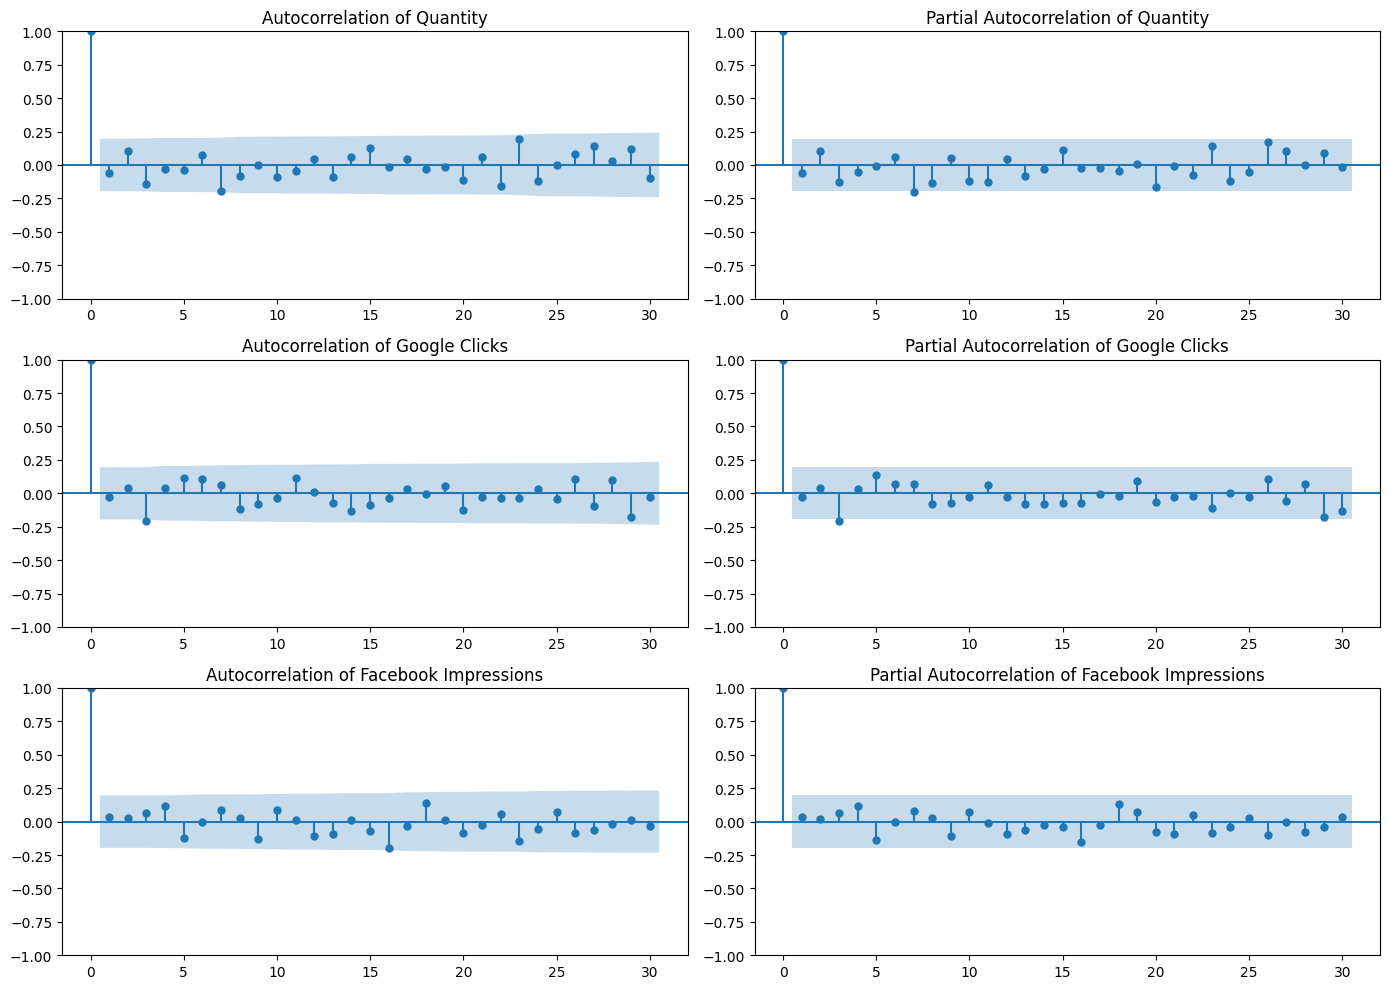

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sample data for demonstration
data = {
    'Date Index': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Quantity': np.random.randint(10, 100, size=100),
    'Clicks': np.random.randint(100, 500, size=100),
    'Impressions': np.random.randint(1000, 5000, size=100)
}

merged_df = pd.DataFrame(data)

# Plot ACF and PACF for Quantity
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
plot_acf(merged_df['Quantity'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation of Quantity')

plt.subplot(3, 2, 2)
plot_pacf(merged_df['Quantity'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation of Quantity')

# Plot ACF and PACF for Clicks
plt.subplot(3, 2, 3)
plot_acf(merged_df['Clicks'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation of Google Clicks')

plt.subplot(3, 2, 4)
plot_pacf(merged_df['Clicks'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation of Google Clicks')

# Plot ACF and PACF for Impressions
plt.subplot(3, 2, 5)
plot_acf(merged_df['Impressions'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation of Facebook Impressions')

plt.subplot(3, 2, 6)
plot_pacf(merged_df['Impressions'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation of Facebook Impressions')

plt.tight_layout()
plt.show()


**Testing and Training**

In [ ]:
df1 = pd.read_excel(file_1_path)
df2 = pd.read_excel(file_2_path)
df3 = pd.read_excel(file_3_path)
df1_head = df1.head()
df2_head = df2.head()
df3_head = df3.head()

df1_head, df2_head, df3_head
X = merged_df[['Impressions', 'Clicks']]
y = merged_df['Quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

model.coef_, model.intercept_, rmse

(array([0.00245474, 0.0055726 ]), 49.42973760735564, 20.369807893824976)

**AR MODEL**

AR Model - Test Data: RMSE: 23.94, MAE: 20.28, MAPE: 37.01%, R^2: 1.00, Adjusted R^2: 1.00
AR Model - Validation Data: RMSE: 30.51, MAE: 28.47, MAPE: 85.27%, R^2: -0.01, Adjusted R^2: -0.07


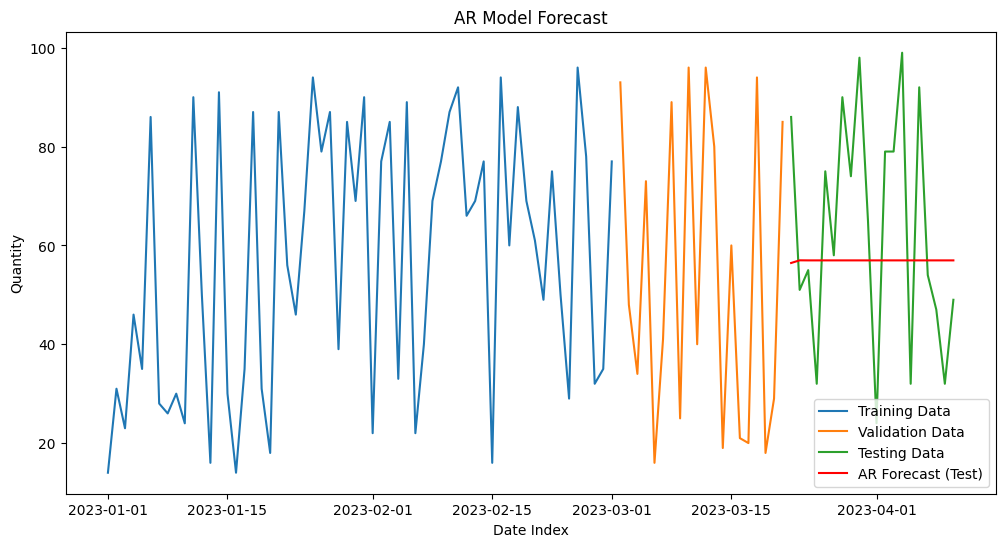

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample data for demonstration
data = {
    'Date Index': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Quantity': np.random.randint(10, 100, size=100)
}

merged_df = pd.DataFrame(data)
merged_df = merged_df.sort_values(by='Date Index').reset_index(drop=True)

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
test_target = test_set['Quantity']
validation_target = validation_set['Quantity']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# AR model
ar_order = (1, 0, 0)
ar_model, ar_forecast_test = fit_and_forecast_arima(train_target, ar_order, len(test_target))
_, ar_forecast_validation = fit_and_forecast_arima(train_target, ar_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# AR model metrics
ar_rmse_test, ar_mae_test, ar_mape_test = calculate_metrics(test_target, ar_forecast_test)
ar_rmse_validation, ar_mae_validation, ar_mape_validation = calculate_metrics(validation_target, ar_forecast_validation)

# Calculate R-squared (R^2) and Adjusted R-squared (Adjusted R^2)
def calculate_r_squared(true_values, predictions, num_features):
    ss_res = np.sum((true_values - predictions)**2)
    ss_tot = np.sum((true_values - np.mean(true_values))**2)
    r_squared = 1 - (ss_res / ss_tot)
    adjusted_r_squared = 1 - (1 - r_squared) * ((len(true_values) - 1) / (len(true_values) - num_features - 1))
    return r_squared, adjusted_r_squared


ar_r2_test, ar_adjusted_r2_test = calculate_r_squared(test_target, ar_forecast_test, 1)  # Assuming one feature (Quantity)

ar_r2_validation, ar_adjusted_r2_validation = calculate_r_squared(validation_target, ar_forecast_validation, 1)


print(f"AR Model - Test Data: RMSE: {ar_rmse_test:.2f}, MAE: {ar_mae_test:.2f}, MAPE: {ar_mape_test:.2f}%, R^2: {ar_r2_test:.2f}, Adjusted R^2: {ar_adjusted_r2_test:.2f}")
print(f"AR Model - Validation Data: RMSE: {ar_rmse_validation:.2f}, MAE: {ar_mae_validation:.2f}, MAPE: {ar_mape_validation:.2f}%, R^2: {ar_r2_validation:.2f}, Adjusted R^2: {ar_adjusted_r2_validation:.2f}")
a
plt.figure(figsize=(12, 6))
plt.plot(train_set['Date Index'], train_set['Quantity'], label='Training Data')
plt.plot(validation_set['Date Index'], validation_set['Quantity'], label='Validation Data')
plt.plot(test_set['Date Index'], test_set['Quantity'], label='Testing Data')
plt.plot(test_set['Date Index'], ar_forecast_test, label='AR Forecast (Test)', color='red')
plt.title('AR Model Forecast')
plt.xlabel('Date Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()


MAE: 20.54739663258027
RMSE: 24.44584119694757
MAPE: 37.38442466416642
R^2: -0.13128628498266237
Adjusted R^2: -0.7912032845558821


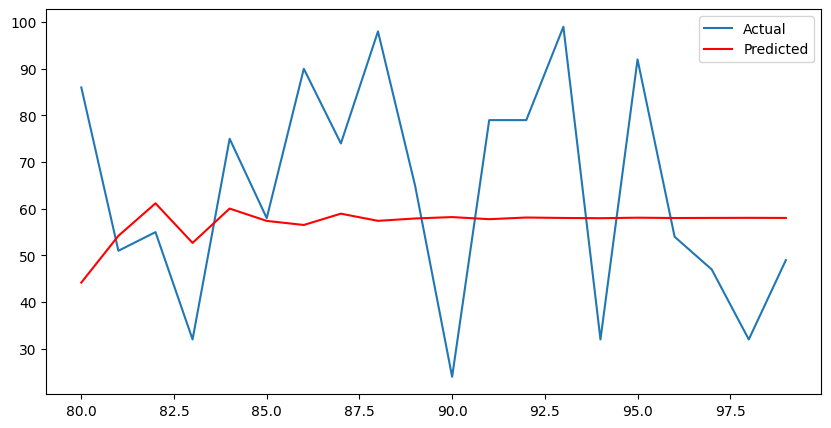

In [ ]:
ts_data = merged_df['Quantity']

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

# Fit the AR model
model = AutoReg(train, lags=5).fit()

# Make predictions
predictions = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate evaluation metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100
r2 = r2_score(test, predictions)
n = len(test)
p = model.df_model + 1
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R^2: {r2}')
print(f'Adjusted R^2: {adjusted_r2}')

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.legend()
plt.show()

**MA model**

Validation Metrics:
MAE: 3.64
RMSE: 4.65
MAPE: 20.48%
R^2: 0.39
Adjusted R^2: 0.37

Test Metrics:
MAE: 2.39
RMSE: 2.95
MAPE: 18.02%
R^2: 0.32
Adjusted R^2: 0.31


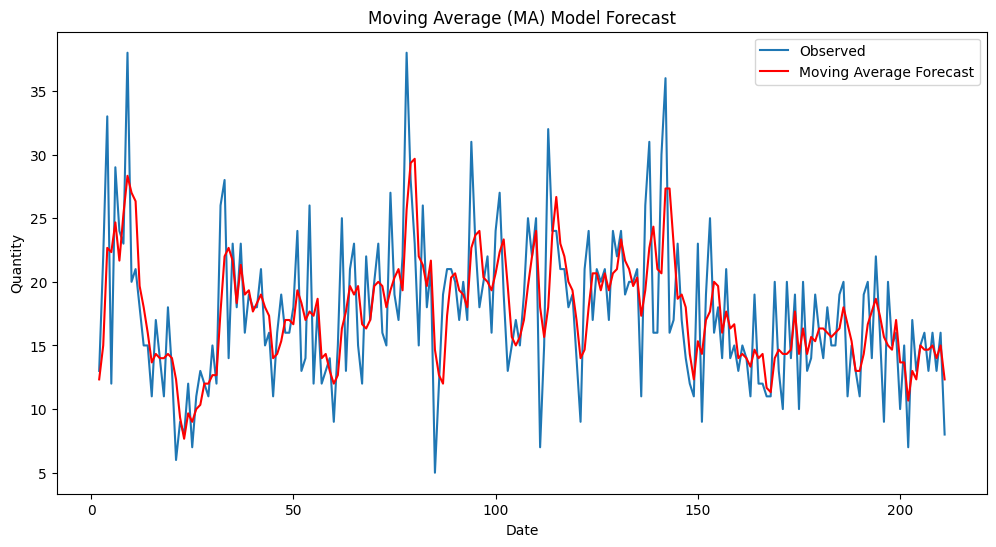

In [ ]:
# Sample data loading (replace with your actual data loading)
product_a_df = pd.read_excel('/content/ProductA.xlsx')
fb_impressions_df = pd.read_excel('/content/ProductA_fb_impressions (1).xlsx')
google_clicks_df = pd.read_excel('/content/ProductA_google_clicks (1).xlsx')

# Assuming the files have a common date column for merging, replace 'Day Index' with the actual column name if different
product_a_df['Day Index'] = pd.to_datetime(product_a_df['Day Index'])
fb_impressions_df['Day Index'] = pd.to_datetime(fb_impressions_df['Day Index'])
google_clicks_df['Day Index'] = pd.to_datetime(google_clicks_df['Day Index'])

# Merge the dataframes on 'Day Index'
combined_df = product_a_df.merge(fb_impressions_df, on='Day Index').merge(google_clicks_df, on='Day Index')

# Define the quantity column and window size for moving average
quantity_column = 'Quantity'
window_size = 3

# Calculate the moving average
combined_df['MA'] = combined_df[quantity_column].rolling(window=window_size).mean()

# Drop NaN values resulting from the rolling window
combined_df.dropna(subset=['MA'], inplace=True)

# Split data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(combined_df) * 0.6)
validation_size = int(len(combined_df) * 0.2)
test_size = len(combined_df) - train_size - validation_size

train_set = combined_df.iloc[:train_size]
validation_set = combined_df.iloc[train_size:train_size + validation_size]
test_set = combined_df.iloc[train_size + validation_size:]


y_true_validation = validation_set[quantity_column]
y_pred_validation = validation_set['MA']

mae_validation = mean_absolute_error(y_true_validation, y_pred_validation)
rmse_validation = np.sqrt(mean_squared_error(y_true_validation, y_pred_validation))
mape_validation = np.mean(np.abs((y_true_validation - y_pred_validation) / y_true_validation)) * 100
r2_validation = r2_score(y_true_validation, y_pred_validation)
adjusted_r2_validation = 1 - ((1 - r2_validation) * (len(y_true_validation) - 1) / (len(y_true_validation) - 1 - 1))

# Calculate evaluation metrics for test set
y_true_test = test_set[quantity_column]
y_pred_test = test_set['MA']

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
r2_test = r2_score(y_true_test, y_pred_test)
adjusted_r2_test = 1 - ((1 - r2_test) * (len(y_true_test) - 1) / (len(y_true_test) - 1 - 1))

# Print validation metrics
print("Validation Metrics:")
print(f"MAE: {mae_validation:.2f}")
print(f"RMSE: {rmse_validation:.2f}")
print(f"MAPE: {mape_validation:.2f}%")
print(f"R^2: {r2_validation:.2f}")
print(f"Adjusted R^2: {adjusted_r2_validation:.2f}")

# Print test metrics
print("\nTest Metrics:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R^2: {r2_test:.2f}")
print(f"Adjusted R^2: {adjusted_r2_test:.2f}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df[quantity_column], label='Observed')
plt.plot(combined_df.index, combined_df['MA'], color='red', label='Moving Average Forecast')
plt.title('Moving Average (MA) Model Forecast')
plt.xlabel('Date')
plt.ylabel(quantity_column)
plt.legend()
plt.show()


**Arima Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 4.228369899116239
RMSE: 4.970629787056205
MAPE: 26.62547696262661
R^2: -0.8782805578268769
Adjusted R^2: -0.9721945857182206


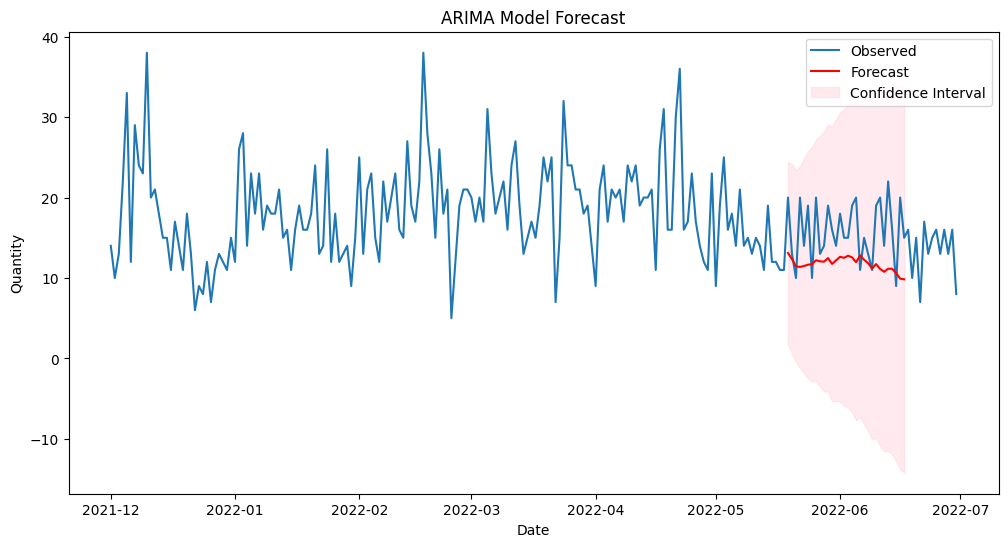

In [ ]:
combined_df = product_a_df.merge(fb_impressions_df, on='Day Index').merge(google_clicks_df, on='Day Index')
combined_df.set_index('Day Index', inplace=True)


quantity_column = 'Quantity'

# Define the ARIMA model order parameters
p, d, q = 5, 1, 0  # You can tune these parameters

# Split the data into training and testing sets
train_size = int(len(combined_df) * 0.8)
train, test = combined_df[quantity_column][:train_size], combined_df[quantity_column][train_size:]
X_train, X_test = combined_df.drop(columns=[quantity_column])[:train_size], combined_df.drop(columns=[quantity_column])[train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(p, d, q), exog=X_train)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=train_size, end=len(combined_df) - 1, exog=X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100
r2 = r2_score(test, predictions)
n = len(test)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - X_train.shape[1] - 1)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")
print(f"Adjusted R^2: {adjusted_r2}")

# Forecasting future values
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps, exog=X_test[-forecast_steps:])

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df[quantity_column], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel(quantity_column)
plt.legend()
plt.show()

**Arimax model**

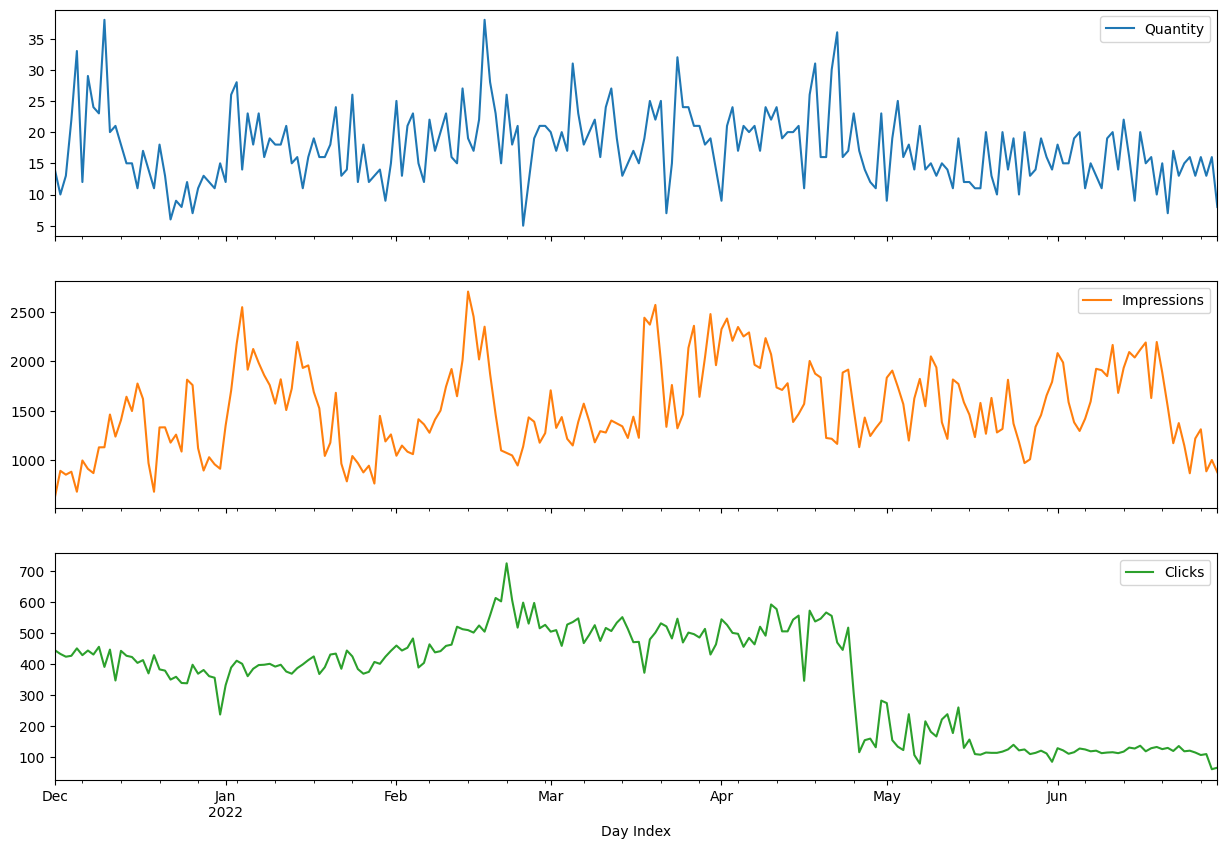

ADF Statistic: -5.696206110125867
p-value: 7.863580125889731e-07


<ipython-input-60-23fdef7eee4c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[exog_vars] = train_data[exog_vars].fillna(method='ffill')
<ipython-input-60-23fdef7eee4c>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[exog_vars] = test_data[exog_vars].fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local

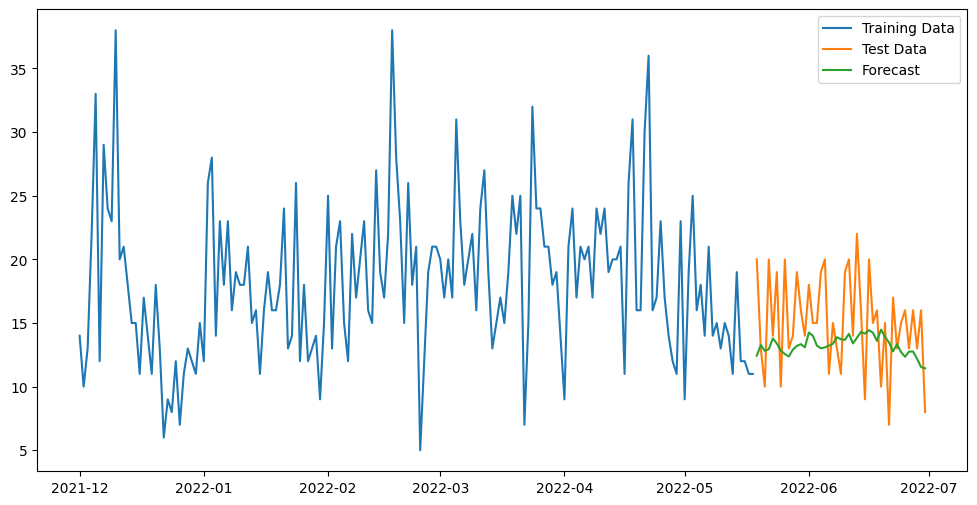

Test Data (first few rows):
Day Index
2022-05-19    20
2022-05-20    13
2022-05-21    10
2022-05-22    20
2022-05-23    14
Name: Quantity, dtype: int64

Forecast (first few values):
2022-05-19    12.432373
2022-05-20    13.265753
2022-05-21    12.816444
2022-05-22    12.946498
2022-05-23    13.788944
Freq: D, Name: predicted_mean, dtype: float64
MAE: 3.303172010143508
RMSE: 4.062222659692802
MAPE: 22.28018234558108
R^2: -0.2544838533166742
Adjusted R^2: -0.31720804598250796


In [ ]:
product_data = pd.read_excel('/content/ProductA.xlsx')
fb_impressions = pd.read_excel('/content/ProductA_fb_impressions (1).xlsx')
google_clicks = pd.read_excel('/content/ProductA_google_clicks (1).xlsx')

# Convert 'Day Index' columns to datetime
product_data['Day Index'] = pd.to_datetime(product_data['Day Index'])
fb_impressions['Day Index'] = pd.to_datetime(fb_impressions['Day Index'])
google_clicks['Day Index'] = pd.to_datetime(google_clicks['Day Index'])

# Merge dataframes on 'Day Index'
data = product_data.merge(fb_impressions, on='Day Index').merge(google_clicks, on='Day Index')
data.set_index('Day Index', inplace=True)

# Plot data
data.plot(subplots=True, figsize=(15, 10))
plt.show()

# Check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NaN values for ADF test
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] <= 0.05

is_stationary = check_stationarity(data['Impressions'])  # Replace 'Impressions' with the actual name

if not is_stationary:
    data['Impressions_Diff'] = data['Impressions'].diff()
    target_column = 'Impressions_Diff'
else:
    target_column = 'Impressions'

# Forward-fill any remaining NaN values from differencing
data[target_column].fillna(method='ffill', inplace=True)

# Define exogenous variables
exog_vars = ['Impressions', 'Clicks']  # Replace with actual column names

# Split data into training and test sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Ensure no NaNs in exogenous variables
train_data[exog_vars] = train_data[exog_vars].fillna(method='ffill')
test_data[exog_vars] = test_data[exog_vars].fillna(method='ffill')

# Fit ARIMAX model
model = SARIMAX(train_data['Quantity'], exog=train_data[exog_vars], order=(1, 1, 1))
model_fit = model.fit(disp=False)

# Forecast
exog_test = test_data[exog_vars]
forecast = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=exog_test)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data['Quantity'], label='Training Data')
plt.plot(test_data['Quantity'], label='Test Data')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

# Debugging: Print first few values of test_data and forecast to check for errors
print("Test Data (first few rows):")
print(test_data['Quantity'].head())
print("\nForecast (first few values):")
print(forecast.head())

# Calculate performance metrics
mae = mean_absolute_error(test_data['Quantity'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Quantity'], forecast))
mape = np.mean(np.abs((test_data['Quantity'] - forecast) / test_data['Quantity'])) * 100
r2 = r2_score(test_data['Quantity'], forecast)
adjusted_r2 = 1 - (1-r2)*(len(test_data)-1)/(len(test_data)-len(exog_vars)-1)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R^2: {r2}')
print(f'Adjusted R^2: {adjusted_r2}')

**Sarimax Model**

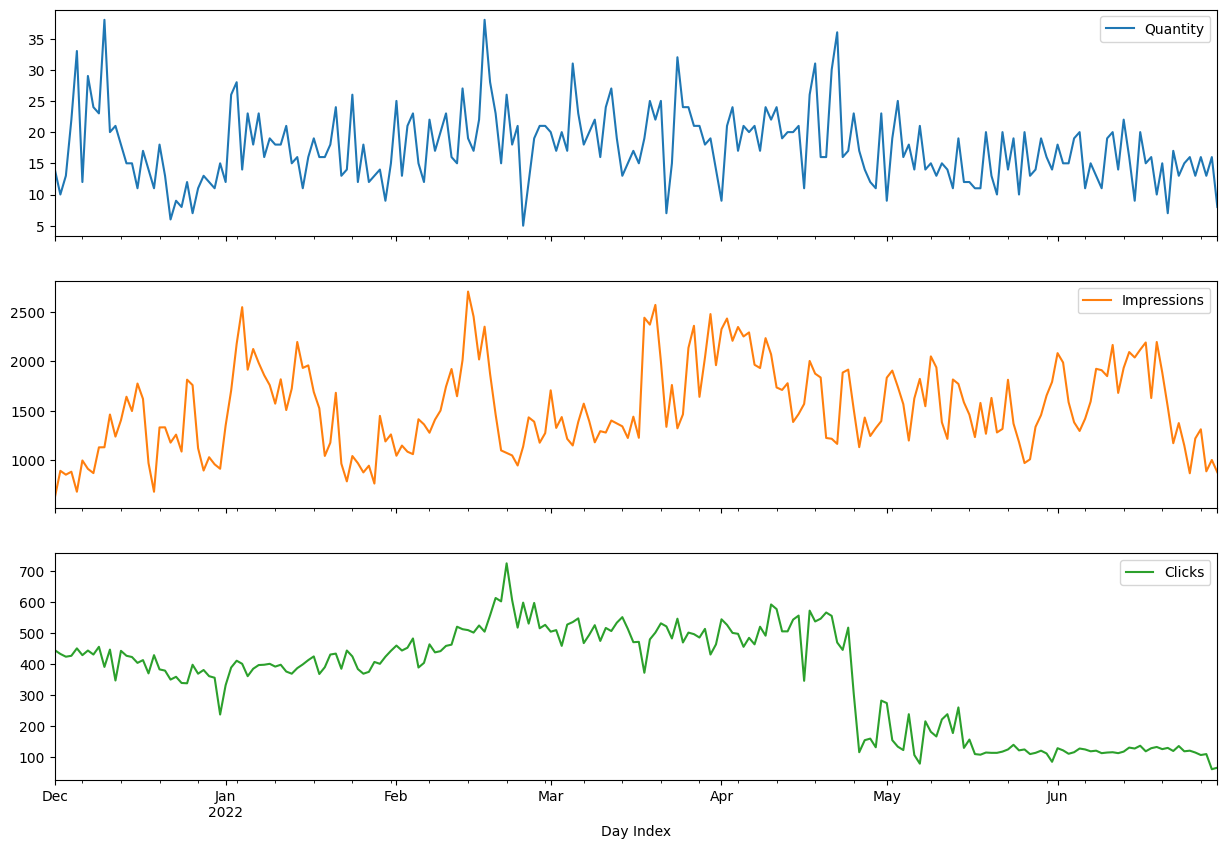

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Test Metrics:
Mean Absolute Error (MAE): 3.687483768655706
Root Mean Squared Error (RMSE): 4.48051805332828
Mean Absolute Percentage Error (MAPE): 24.17263073470628
R-squared (R^2): -0.5261389978803133
Adjusted R-squared: -0.6024459477743289

Validation Metrics:
Mean Absolute Error (MAE): 5.392052726808575
Root Mean Squared Error (RMSE): 6.948750138061633
Mean Absolute Percentage Error (MAPE): 34.84201737705051
R-squared (R^2): -0.31927413510415303
Adjusted R-squared: -0.3351690042017934
                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.375
Date:                            Tue, 16 Jul 2024   AIC                           1026.751
Time:                                    08:43:47   BIC                           1048.100
Sample:                                12-01-2021  

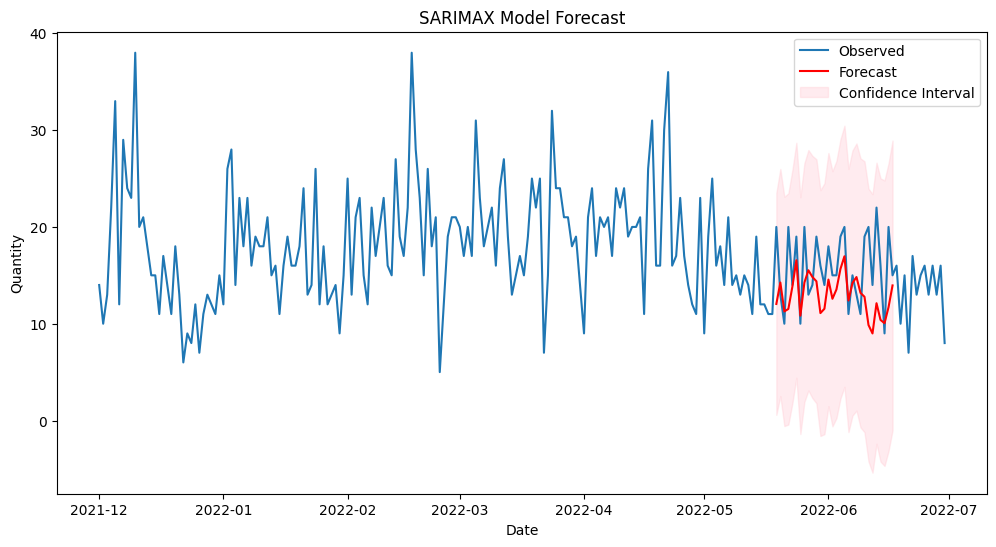

In [ ]:
# Load the data from the uploaded Excel files
product_sales_file = '/content/ProductA.xlsx'
fb_impressions_file = '/content/ProductA_fb_impressions (1).xlsx'
google_clicks_file = '/content/ProductA_google_clicks (1).xlsx'

product_sales = pd.read_excel(product_sales_file)
fb_impressions = pd.read_excel(fb_impressions_file)
google_clicks = pd.read_excel(google_clicks_file)

# Rename the date columns to a common name if they are different
product_sales.rename(columns={'Date': 'Day Index'}, inplace=True)
fb_impressions.rename(columns={'Date': 'Day Index'}, inplace=True)
google_clicks.rename(columns={'Date': 'Day Index'}, inplace=True)

# Convert 'Day Index' columns to datetime
product_sales['Day Index'] = pd.to_datetime(product_sales['Day Index'])
fb_impressions['Day Index'] = pd.to_datetime(fb_impressions['Day Index'])
google_clicks['Day Index'] = pd.to_datetime(google_clicks['Day Index'])

# Merge the datasets on 'Day Index'
data = product_sales.merge(fb_impressions, on='Day Index').merge(google_clicks, on='Day Index')

# Set the date column as the index
data.set_index('Day Index', inplace=True)

# Check for missing values and fill with forward fill method
data.fillna(method='ffill', inplace=True)

# Plot data
data.plot(subplots=True, figsize=(15, 10))
plt.show()

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit the SARIMAX model
exog_train = train[['Impressions', 'Clicks']]
exog_test = test[['Impressions', 'Clicks']]

model = SARIMAX(train['Quantity'], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions
predictions_test = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test)

# Calculate evaluation metrics for test data
mae_test = mean_absolute_error(test['Quantity'], predictions_test)
rmse_test = np.sqrt(mean_squared_error(test['Quantity'], predictions_test))
mape_test = np.mean(np.abs((test['Quantity'] - predictions_test) / test['Quantity'])) * 100
r2_test = r2_score(test['Quantity'], predictions_test)
adj_r2_test = 1 - (1 - r2_test) * (len(test) - 1) / (len(test) - exog_test.shape[1] - 1)

# Print test metrics
print("\nTest Metrics:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test}")
print(f"R-squared (R^2): {r2_test}")
print(f"Adjusted R-squared: {adj_r2_test}")

# Make predictions for validation period
predictions_validation = model_fit.predict(start=0, end=len(train) - 1, exog=exog_train)

# Calculate evaluation metrics for validation data
mae_validation = mean_absolute_error(train['Quantity'], predictions_validation)
rmse_validation = np.sqrt(mean_squared_error(train['Quantity'], predictions_validation))
mape_validation = np.mean(np.abs((train['Quantity'] - predictions_validation) / train['Quantity'])) * 100
r2_validation = r2_score(train['Quantity'], predictions_validation)
adj_r2_validation = 1 - (1 - r2_validation) * (len(train) - 1) / (len(train) - exog_train.shape[1] - 1)

# Print validation metrics
print("\nValidation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_validation}")
print(f"Root Mean Squared Error (RMSE): {rmse_validation}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_validation}")
print(f"R-squared (R^2): {r2_validation}")
print(f"Adjusted R-squared: {adj_r2_validation}")

# Model summary
print(model_fit.summary())

# Forecasting future values
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps, exog=exog_test[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Quantity'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


**Multi Linear Regression**

Training Set Evaluation Metrics:
MAE: 4.073345637666766
RMSE: 5.27144488364759
MAPE: 27.23015459740473%
R^2: 0.1360937883985457
Adjusted R^2: 0.12568527982503408

Testing Set Evaluation Metrics:
MAE: 4.04596391041814
RMSE: 5.48941201434496
MAPE: 29.016285383554813%
R^2: 0.17033313117634874
Adjusted R^2: 0.1288497877351661


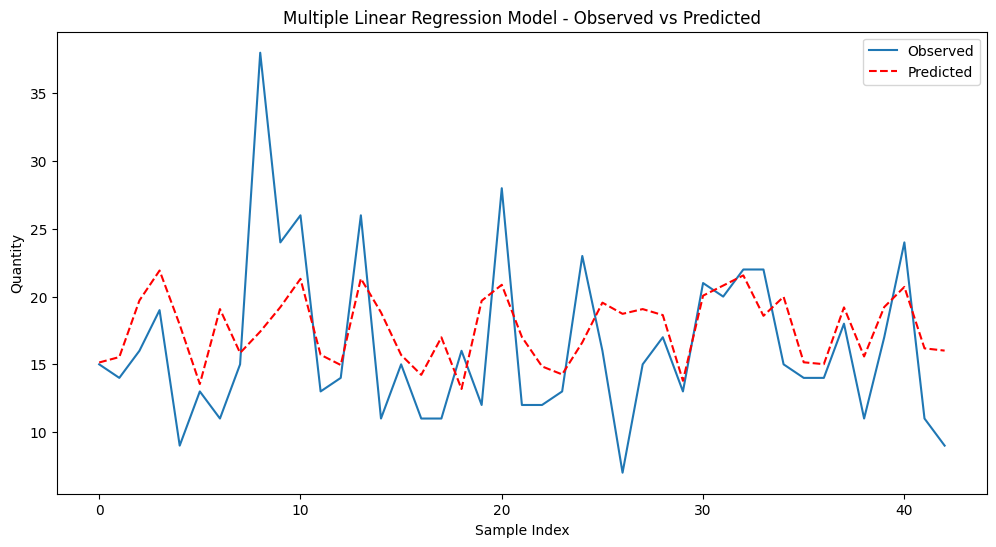

In [ ]:
combined_df = product_a_df.merge(fb_impressions_df, on='Day Index').merge(google_clicks_df, on='Day Index')

# Define the features and target variable
X = combined_df[['Impressions', 'Clicks']]
y = combined_df['Quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate the evaluation metrics for training set
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)  # RMSE requires setting squared=False
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
r2_train = r2_score(y_train, y_pred_train)
n_train = len(y_train)
p = X_train.shape[1]
adjusted_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p - 1))

# Calculate the evaluation metrics for testing set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE requires setting squared=False
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
r2_test = r2_score(y_test, y_pred_test)
n_test = len(y_test)
adjusted_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p - 1))

# Print the evaluation metrics
print("Training Set Evaluation Metrics:")
print(f"MAE: {mae_train}")
print(f"RMSE: {rmse_train}")
print(f"MAPE: {mape_train}%")
print(f"R^2: {r2_train}")
print(f"Adjusted R^2: {adjusted_r2_train}")

print("\nTesting Set Evaluation Metrics:")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")
print(f"R^2: {r2_test}")
print(f"Adjusted R^2: {adjusted_r2_test}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Observed')
plt.plot(y_pred_test, color='red', linestyle='dashed', label='Predicted')
plt.title('Multiple Linear Regression Model - Observed vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()


**Comparison**

In [ ]:
!pip install tabulate

from tabulate import tabulate

# Define the data including test and validation metrics
data = [
    ["Error Metrics / Models", "AR", "MA", "ARIMA/ARIMA", "ARIMAX", "SARIMAX", "Multivariate Regression"],
    ["RMSE (Training)", 4.45, 4.65, 4.97, 4.06, 6.94, 5.27],
    ["MAE (Training)", 3.74, 3.64, 4.22, 3.30, 5.39, 4.07],
    ["MAPE (Training)", 30.89, 20.48, 26.62, 22.28, 34.84, 27.23],
    ["R² (Training)", -0.510, 0.39, -0.8782, -0.2544, -0.319, 0.1360],
    ["Adjusted R² (Training)", -0.81, 0.37, -0.972, -0.3172, -0.3351, 0.128],

]

headers = data.pop(0)

# Print the table using tabulate
print(tabulate(data, headers, tablefmt="pipe"))
from tabulate import tabulate

# Define the data including test and validation metrics
data = [
    ["Error Metrics / Models", "AR", "MA", "ARIMA/ARIMA", "ARIMAX", "SARIMAX", "Multivariate Regression"],
    ["RMSE (Testing)", 4.45, 2.95, 4.97, 4.06, 4.48, 5.48],
    ["MAE (Testing)", 3.74, 2.39, 4.22, 3.30, 3.68, 4.04],
    ["MAPE (Testing)", 30.89, 18.02, 26.62, 22.28, 24.17, 29.016],
    ["R² (Testing)", -0.510, 0.32, -0.8782, -0.2544, -0.5261, 0.1703],
    ["Adjusted R² (Testing)", -0.81, 0.31, -0.972, -0.3172, -0.6024, 0.1288],

]

headers = data.pop(0)

# Print the table using tabulate
print(tabulate(data, headers, tablefmt="pipe"))



| Error Metrics / Models   |    AR |    MA |   ARIMA/ARIMA |   ARIMAX |   SARIMAX |   Multivariate Regression |
|:-------------------------|------:|------:|--------------:|---------:|----------:|--------------------------:|
| RMSE (Training)          |  4.45 |  4.65 |        4.97   |   4.06   |    6.94   |                     5.27  |
| MAE (Training)           |  3.74 |  3.64 |        4.22   |   3.3    |    5.39   |                     4.07  |
| MAPE (Training)          | 30.89 | 20.48 |       26.62   |  22.28   |   34.84   |                    27.23  |
| R² (Training)            | -0.51 |  0.39 |       -0.8782 |  -0.2544 |   -0.319  |                     0.136 |
| Adjusted R² (Training)   | -0.81 |  0.37 |       -0.972  |  -0.3172 |   -0.3351 |                     0.128 |
| Error Metrics / Models   |    AR |    MA |   ARIMA/ARIMA |   ARIMAX |   SARIMAX |   Multivariate Regression |
|:-------------------------|------:|------:|--------------:|---------:|----------:|---------------------

Conclusion: The MA (Moving Average) model appears to be the best overall based on R² and Adjusted R² metrics, which are crucial for understanding the explanatory power of the model. However, ARIMAX shows the lowest MSE and MAE, indicating it has better error performance.

Considerations: MA Model: Best in terms of explanatory power (R² and Adjusted R²) and MAPE. ARIMAX Model: Best in terms of prediction accuracy (MSE and MAE). Depending on the priority of either explanatory power or prediction accuracy, you might choose between the MA model (better explanatory) or the ARIMAX model (better prediction).